<a href="https://colab.research.google.com/github/mrcruz117/Prophet-Forecast/blob/main/Prophet_Forecast_Dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prophet - Parameter Tuning
- dev env

In [63]:
#change directory
%cd /content/drive/MyDrive/Time Series Forecasting Product

/content/drive/MyDrive/Time Series Forecasting Product


In [64]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# to hide all the unnecessary prophet logs
import logging
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

In [65]:
#load the data
#YYYY-MM-DD
df = pd.read_csv('nyc_data.csv')
future_df = pd.read_csv('future.csv')
future_df.tail()

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
26,1/27/2021,NaN,0,0,0,3.33,39.664
27,1/28/2021,NaN,0,0,0,1.67,195.314
28,1/29/2021,NaN,0,0,0,-2.78,235.894
29,1/30/2021,NaN,0,0,0,1.11,152.752
30,1/31/2021,NaN,0,0,0,4.44,158.620


In [66]:
# merge df and future_df
df = pd.concat([df, future_df])

# reset index
df = df.reset_index(drop=True)
df.tail()

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
2218,1/27/2021,NaN,0,0,0,3.33,39.664
2219,1/28/2021,NaN,0,0,0,1.67,195.314
2220,1/29/2021,NaN,0,0,0,-2.78,235.894
2221,1/30/2021,NaN,0,0,0,1.11,152.752
2222,1/31/2021,NaN,0,0,0,4.44,158.620


In [67]:
#Rename variable
df = df.rename(columns = {'Demand': 'y', 'Date' : 'ds'})
df.head(0)

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing


In [81]:
# Transforming Date: YYYY-MM-DD
df.ds = pd.to_datetime(df.ds, format = '%m/%d/%Y')

In [82]:
df.head()

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,2015-01-01,720.000885,0,0,0,3.68,41.305
1,2015-01-02,581.276773,0,0,0,4.73,131.574
2,2015-01-03,754.117039,0,0,0,7.23,162.700
3,2015-01-04,622.252774,0,0,0,10.96,160.281
4,2015-01-05,785.373319,0,0,0,6.92,51.077


## Holidays

In [70]:
# Easter
dates = df[df.Easter == 1].ds
easter = pd.DataFrame({
    'holiday': 'easter',
    'ds': dates,
    'lower_window': -5,
    'upper_window': 2,
})

In [71]:
# Thanksgiving
dates = df[df.Thanksgiving == 1].ds
thanksgiving = pd.DataFrame({
    'holiday': 'thanksgiving',
    'ds': dates,
    'lower_window': -3,
    'upper_window': 5,
})
# Christmas
dates = df[df.Christmas == 1].ds
christmas = pd.DataFrame({
    'holiday': 'christmas',
    'ds': dates,
    'lower_window': -7,
    'upper_window': 7,
})

In [72]:
# combine all events
holidays = pd.concat([easter, thanksgiving, christmas])

holidays.head(5)

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2


In [84]:
# drop old holidays cols
df_final = df.drop(columns = ['Easter', 'Thanksgiving', 'Christmas'])
df_final.head()

,ds,y,Temperature,Marketing
0,2015-01-01,720.000885,3.68,41.305
1,2015-01-02,581.276773,4.73,131.574
2,2015-01-03,754.117039,7.23,162.700
3,2015-01-04,622.252774,10.96,160.281
4,2015-01-05,785.373319,6.92,51.077


## Parameters
- key parameters
  - **seasonality**: yearly, weekly, daily, etc
  - **seasonality mode**: multiplicative or additive
  - **holidays**
  - **seasonality_prior_scale**: strength of seasonality
  - **holiday_prior_scale**: how much do holidays interfere with the normal seasonal fluxuations
  - **changepoint_prior_scale**: how sensitive is the trendline to changes


## Prophet Model

In [74]:
from prophet import Prophet

In [75]:
# load in tuned params
parameters = pd.read_csv('Forecasting Product/best_params_prophet.csv', index_col=0)
parameters

,0
changepoint_prior_scale,0.01
holidays_prior_scale,5
seasonality_mode,additive
seasonality_prior_scale,5
rmse,48.5


In [76]:
# extract params
cps = float(parameters.loc['changepoint_prior_scale'])
hps = float(parameters.loc['holidays_prior_scale'])
sm = parameters.loc['seasonality_mode'][0]
sps = float(parameters.loc['seasonality_prior_scale'])

# rmse = float(parameters.loc['rmse'])

<ipython-input-76-3539f643fc1a>:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cps = float(parameters.loc['changepoint_prior_scale'])
<ipython-input-76-3539f643fc1a>:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  hps = float(parameters.loc['holidays_prior_scale'])
<ipython-input-76-3539f643fc1a>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sm = parameters.loc['seasonality_mode'][0]
<ipython-input-76-3539f643fc1a>:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sps = float(parameters.loc['seasonality_p

In [85]:
# split data
training = df_final.iloc[:-31, :]
future_df = df_final.iloc[-31:, :]

In [86]:
# building the model
m = Prophet(
    holidays=holidays,
    seasonality_mode=sm,
    seasonality_prior_scale=sps,
    holidays_prior_scale=hps,
    changepoint_prior_scale=cps
)
m.add_regressor("Temperature")
m.add_regressor("Marketing")
# fit model
m.fit(training)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Forecasting

In [87]:
# Make future df
future = m.make_future_dataframe(
    periods=len(future_df),
    freq= "D", # daily
    # include_history=True
)

future = pd.concat([future, df_final.iloc[:, 2:]], axis = 1)
future.tail()

,ds,Temperature,Marketing
2218,2021-01-27,3.33,39.664
2219,2021-01-28,1.67,195.314
2220,2021-01-29,-2.78,235.894
2221,2021-01-30,1.11,152.752
2222,2021-01-31,4.44,158.620


In [88]:
forcast = m.predict(future)
forcast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Marketing,Marketing_lower,Marketing_upper,Temperature,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,595.534209,627.206335,765.096018,595.534209,595.534209,-3.486016,-3.486016,-3.486016,10.363620,...,-3.991736,-3.991736,-3.991736,95.434191,95.434191,95.434191,0.0,0.0,0.0,693.854268
1,2015-01-02,595.650057,539.303528,675.269177,595.650057,595.650057,0.200008,0.200008,0.200008,9.403404,...,-89.615717,-89.615717,-89.615717,94.113411,94.113411,94.113411,0.0,0.0,0.0,609.751163
2,2015-01-03,595.765904,649.830307,792.332199,595.765904,595.765904,1.471001,1.471001,1.471001,7.117174,...,25.142940,25.142940,25.142940,92.889873,92.889873,92.889873,0.0,0.0,0.0,722.386892
3,2015-01-04,595.881752,570.360905,701.898265,595.881752,595.881752,1.372224,1.372224,1.372224,3.706120,...,-55.462151,-55.462151,-55.462151,91.783185,91.783185,91.783185,0.0,0.0,0.0,637.281130
4,2015-01-05,595.997599,699.587816,837.457846,595.997599,595.997599,-3.086989,-3.086989,-3.086989,7.400667,...,74.013259,74.013259,74.013259,90.808833,90.808833,90.808833,0.0,0.0,0.0,765.133369


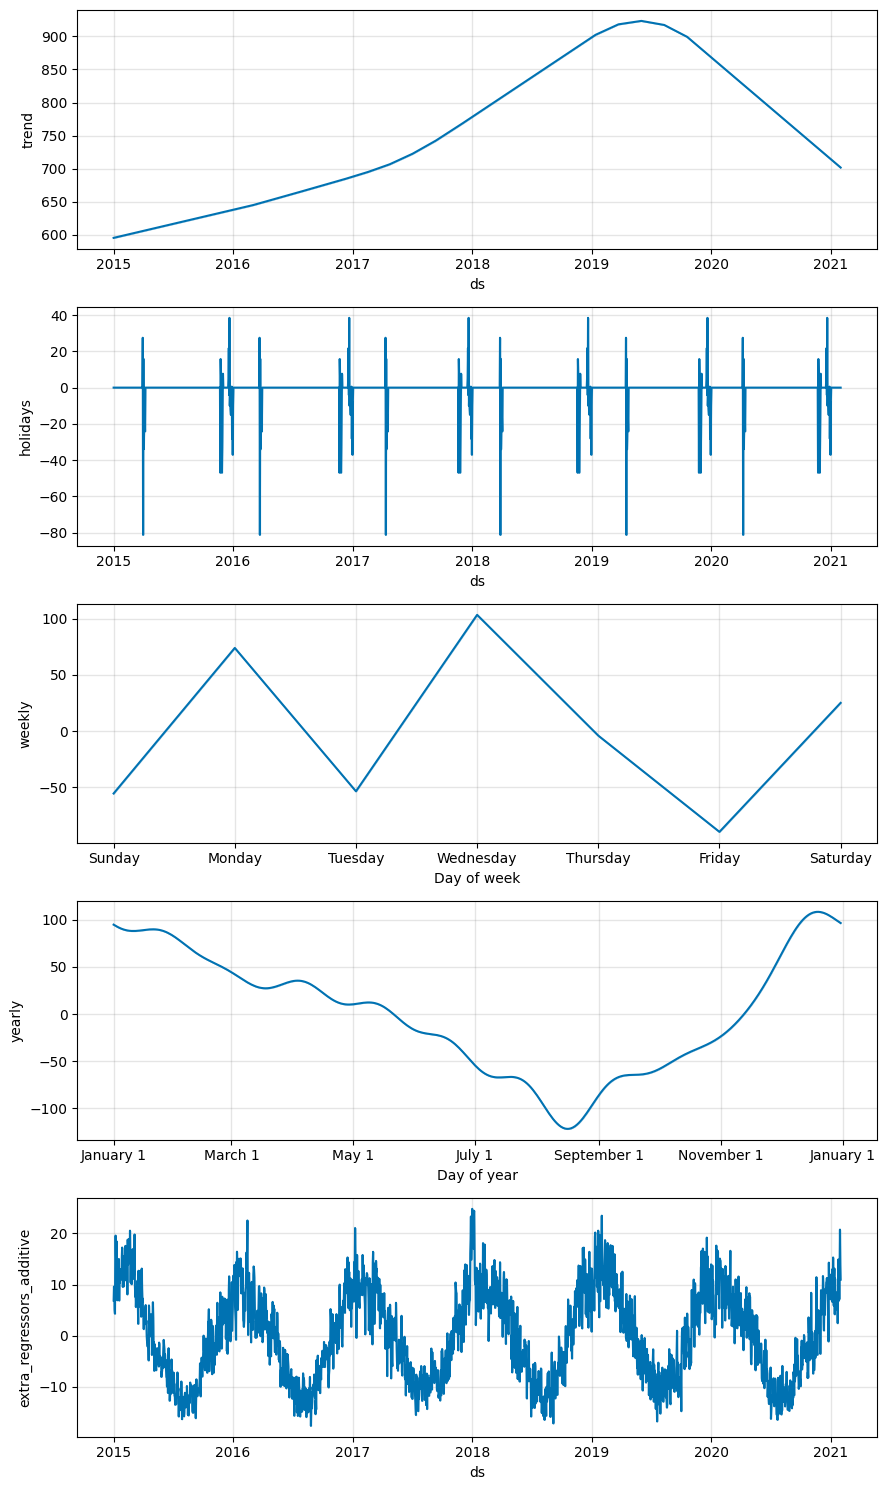

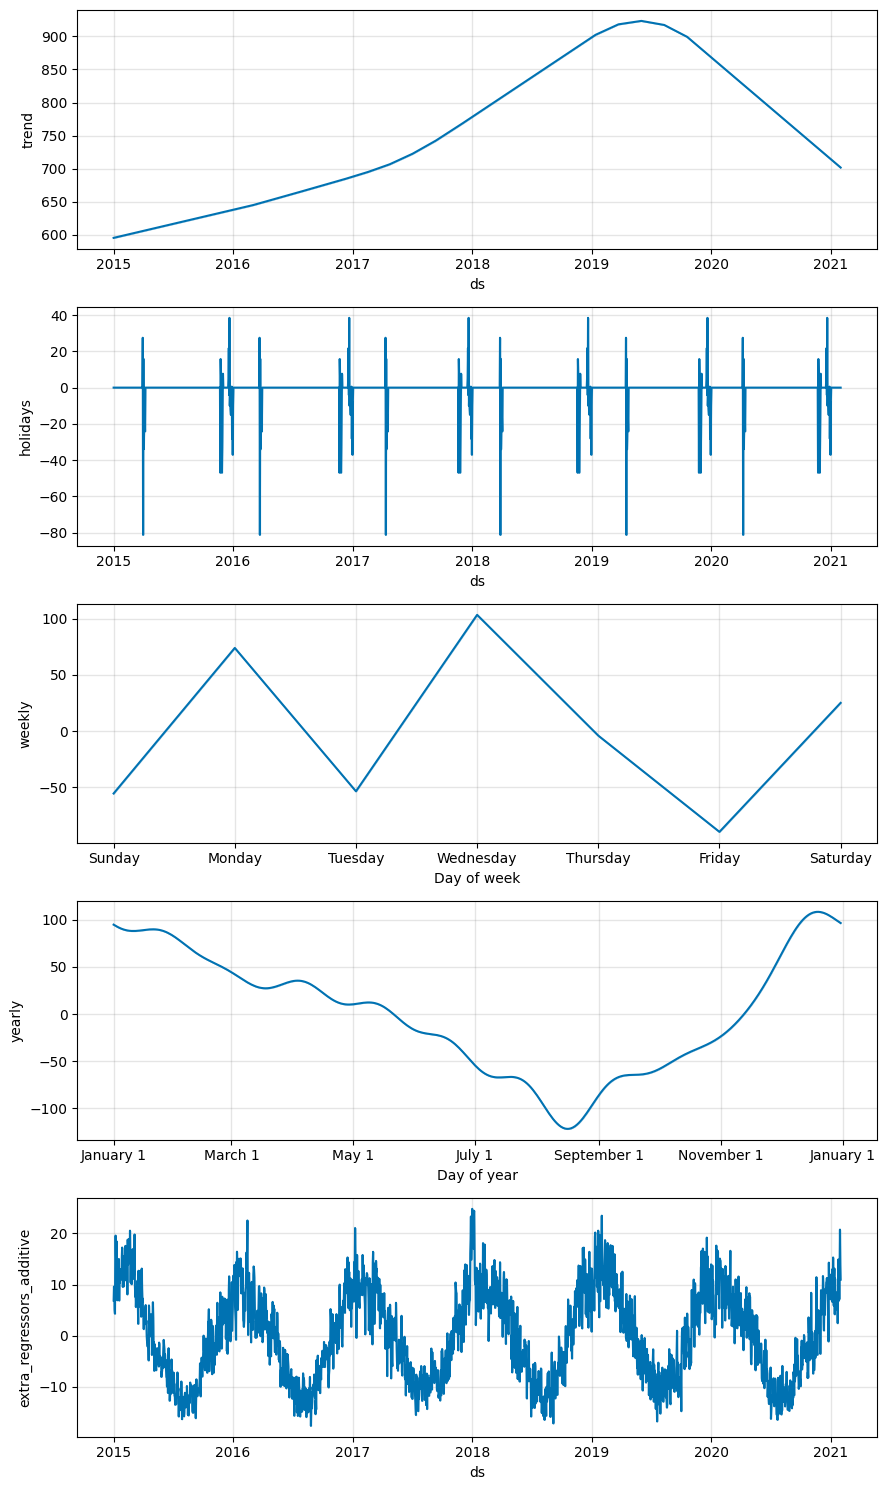

In [90]:
# Components
m.plot_components(forcast)